In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import pandas as pd
import itertools
import calendar

# ESIO Imports

from esio import EsioData as ed
from esio import ice_plot
from esio import metrics

import dask
dask.set_options(get=dask.threaded.get)
# from dask.distributed import Client, progress
# client = Client(processes=12)

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.rcParams.update({'figure.max_open_warning': 0})

#############################################################
# Load in Data
#############################################################
E = ed.EsioData.load()
data_dir = E.data_dir
grid_dir = E.grid_dir
fig_dir = os.path.join(E.fig_dir, 'metrics', 'extent')

In [2]:
ds_region = xr.open_mfdataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))
# "flip" lat/y coordiant (CS and SIPN have different orientation)
ds_region['mask'] = xr.DataArray(np.flip(ds_region.mask.values, axis=1), dims = ds_region.mask.dims, coords = ds_region.mask.coords)
ds_region['area'] = xr.DataArray(np.flip(ds_region.area.values, axis=1), dims = ds_region.area.dims, coords = ds_region.area.coords)
ds_region['hole_mask'] = xr.DataArray(np.flip(ds_region.hole_mask.values, axis=1), dims = ds_region.hole_mask.dims, coords = ds_region.hole_mask.coords)

In [3]:
out_dir = '/home/disk/sipn/nicway/data/Director_data/RPackage/SIPN'

In [4]:
mod_adj_f = 'Mod_adj_traindays_*_month_*.nc'
ds_mod_adj = xr.open_mfdataset(os.path.join(out_dir,'fore_time_test',mod_adj_f), autoclose=True)
ds_mod_adj.rename({'year':'years','month':'months'}, inplace=True);
ds_mod_adj

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, months: 4, years: 1)
Coordinates:
  * years    (years) int32 45
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * months   (months) float64 1.0 5.0 10.0 30.0
Data variables:
    iceInd   (months, lat, lon, years) float32 dask.array<shape=(4, 448, 304, 1), chunksize=(1, 448, 304, 1)>

In [5]:
mod_f = 'Mod_test.nc'
ds_mod = xr.open_mfdataset(os.path.join(out_dir,mod_f), autoclose=True)
ds_mod

<xarray.Dataset>
Dimensions:     (lat: 448, lon: 304, months: 43, years: 365)
Coordinates:
    longitude   (lat, lon) float64 dask.array<shape=(448, 304), chunksize=(448, 304)>
    latitude    (lat, lon) float64 dask.array<shape=(448, 304), chunksize=(448, 304)>
  * months      (months) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * years       (years) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * lon         (lon) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * lat         (lat) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    valid_time  (months, years) datetime64[ns] dask.array<shape=(43, 365), chunksize=(43, 365)>
Data variables:
    iceInd      (lat, lon, months, years) float32 dask.array<shape=(448, 304, 43, 365), chunksize=(448, 304, 43, 365)>

In [6]:
obs_f = 'Obs_test.nc'
ds_obs = xr.open_mfdataset(os.path.join(out_dir,obs_f), autoclose=True)
ds_obs

<xarray.Dataset>
Dimensions:     (lat: 448, lon: 304, months: 43, years: 365)
Coordinates:
  * lon         (lon) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * lat         (lat) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    latitude    (lat, lon) float64 dask.array<shape=(448, 304), chunksize=(448, 304)>
    longitude   (lat, lon) float64 dask.array<shape=(448, 304), chunksize=(448, 304)>
  * months      (months) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * years       (years) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    valid_time  (months, years) datetime64[ns] dask.array<shape=(43, 365), chunksize=(43, 365)>
Data variables:
    conc        (lat, lon, months, years) int16 dask.array<shape=(448, 304, 43, 365), chunksize=(448, 304, 43, 365)>

In [7]:
# Set adjusted month (hardcoded for now, change to come from R code)
# ds_mod_adj = ds_mod_adj.expand_dims('months')
# ds_mod_adj.coords['months'] = [cmonth]
# ds_mod_adj

In [8]:
ds_mod_adj

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, months: 4, years: 1)
Coordinates:
  * years    (years) int32 45
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * months   (months) float64 1.0 5.0 10.0 30.0
Data variables:
    iceInd   (months, lat, lon, years) float32 dask.array<shape=(4, 448, 304, 1), chunksize=(1, 448, 304, 1)>

In [9]:
print(ds_obs.dims)
print(ds_mod.dims)
print(ds_mod_adj.dims)

Frozen(SortedKeysDict({'lon': 304, 'lat': 448, 'months': 43, 'years': 365}))
Frozen(SortedKeysDict({'lat': 448, 'lon': 304, 'months': 43, 'years': 365}))
Frozen(SortedKeysDict(OrderedDict([('lat', 448), ('lon', 304), ('months', 4), ('years', 1)])))


In [10]:
# Calc sea ice presence from obs and model
# Obs
obs_sip = ds_obs.sel(years=ds_mod_adj.years, months=ds_mod_adj.months).conc
obs_sip = ((obs_sip>=15) & (obs_sip<=100)).where(obs_sip<=100)
obs_sip = obs_sip.rename({'lat':'y','lon':'x'})
# Orig Model
mod_sip = ds_mod.sel(years=ds_mod_adj.years, months=ds_mod_adj.months).iceInd
mod_sip = (mod_sip>0.15).where(mod_sip.notnull())
mod_sip = mod_sip.rename({'lat':'y','lon':'x'})
# Adjusted Model
mod_sip_adj = ds_mod_adj.iceInd
cmask = mod_sip_adj.notnull()
mod_sip_adj = mod_sip_adj.where(mod_sip_adj.isin([0,1]), other=0)
mod_sip_adj = mod_sip_adj.where(cmask)
mod_sip_adj = mod_sip_adj.rename({'lat':'y','lon':'x'})
mod_sip_adj.x.attrs = {}
mod_sip_adj.y.attrs = {}
mod_sip_adj.attrs = {}

In [11]:
print(obs_sip.dims)
print(mod_sip.dims)
print(mod_sip_adj.dims)

('y', 'x', 'months', 'years')
('y', 'x', 'months', 'years')
('months', 'y', 'x', 'years')


In [12]:
## Evaluate 
# IIEE
### Original Model IIEE
IIEE_orig = metrics.IIEE(da_mod=mod_sip, da_obs=obs_sip, region=ds_region, sic_threshold=0.15, testplots=False)
### Adjusted Model IIEE
IIEE_adj = metrics.IIEE(da_mod=mod_sip_adj, da_obs=obs_sip, region=ds_region, sic_threshold=0.15, testplots=False)
### Percent IIEE Reduction

In [13]:
# As dask/lazy array, load it in  now
IIEE_orig.load();
IIEE_adj.load();

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


In [14]:
IIEE_orig

<xarray.DataArray (months: 4, years: 1)>
array([[0.753702],
       [0.849226],
       [1.227642],
       [2.270989]])
Coordinates:
  * months      (months) int64 1 5 10 30
  * years       (years) int64 45
    valid_time  (months, years) datetime64[ns] 2017-02-16 2017-02-20 ...

### Plot IIEE vs. forecast lead time (days)

Text(0.5,0,'Forecast Lead time (Days)')

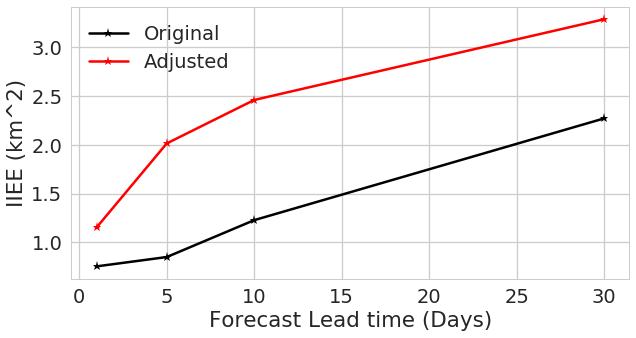

In [15]:
# Plot IIEE
f = plt.figure(figsize=(10,5))
for cyear in IIEE_orig.years:
    plt.plot(IIEE_orig.months.values, IIEE_orig.sel(years=cyear).values, marker='*', label='Original', color='k')
    plt.plot(IIEE_adj.months.values, IIEE_adj.sel(years=cyear).values, marker='*', label='Adjusted', color='r')
plt.legend()
plt.ylabel('IIEE (km^2)')
plt.xlabel('Forecast Lead time (Days)')

### Plot IIEE vs. valid time

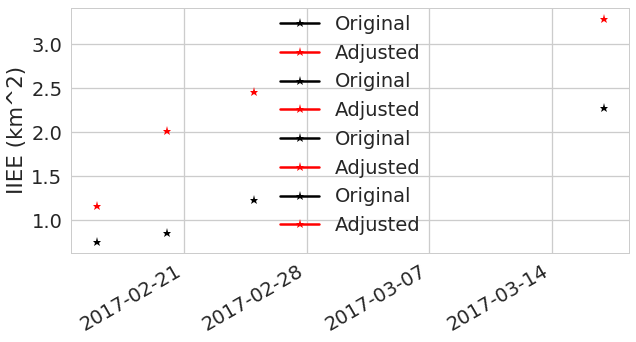

In [16]:
# Plot IIEE
f = plt.figure(figsize=(10,5))
for cmonth in IIEE_orig.months:
    plt.plot(IIEE_orig.valid_time.sel(months=cmonth).values, IIEE_orig.sel(months=cmonth).values, marker='*', label='Original', color='k')
    plt.plot(IIEE_adj.valid_time.sel(months=cmonth).values, IIEE_adj.sel(months=cmonth).values, marker='*', label='Adjusted', color='r')
plt.legend()
plt.ylabel('IIEE (km^2)')
f.autofmt_xdate()

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


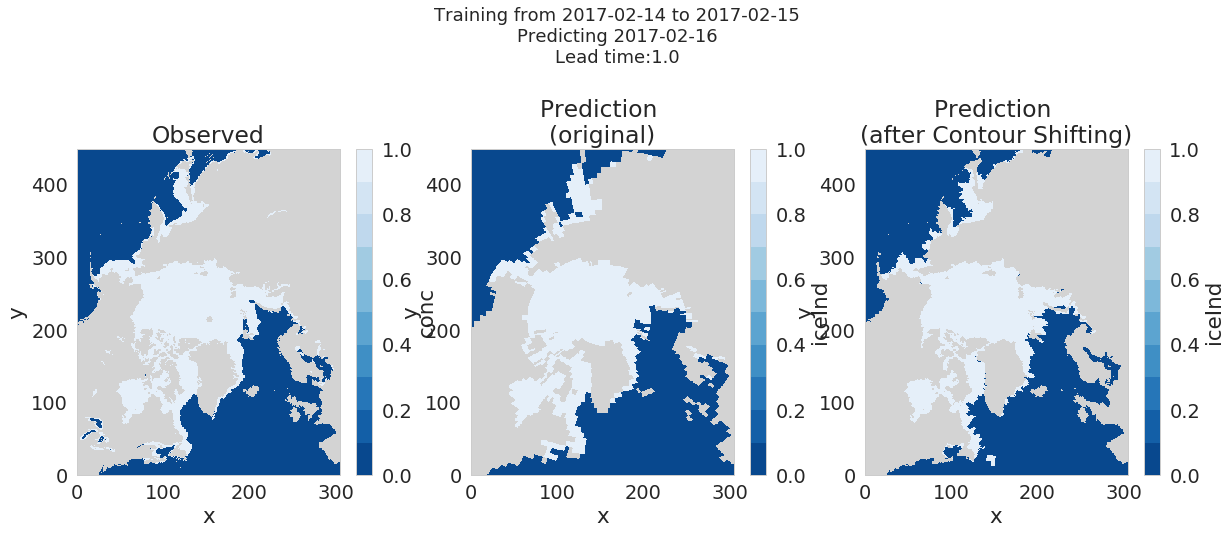

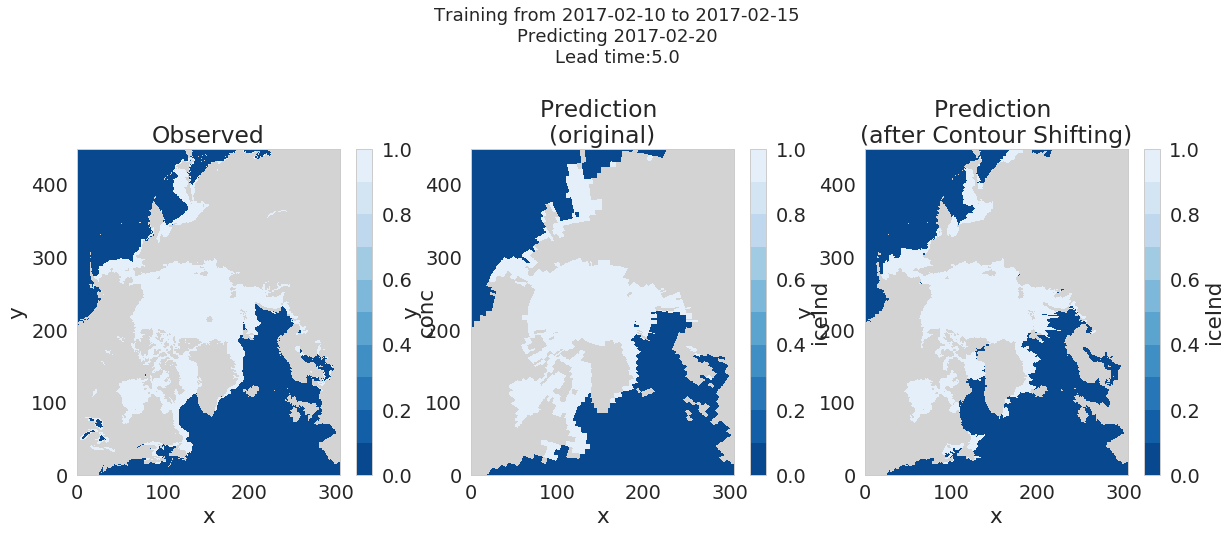

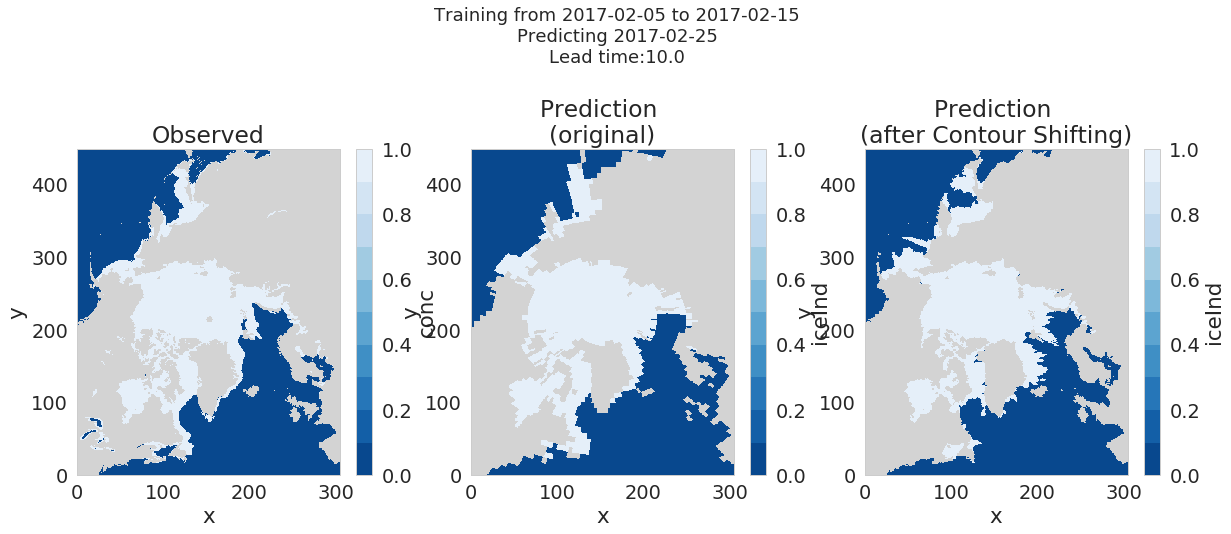

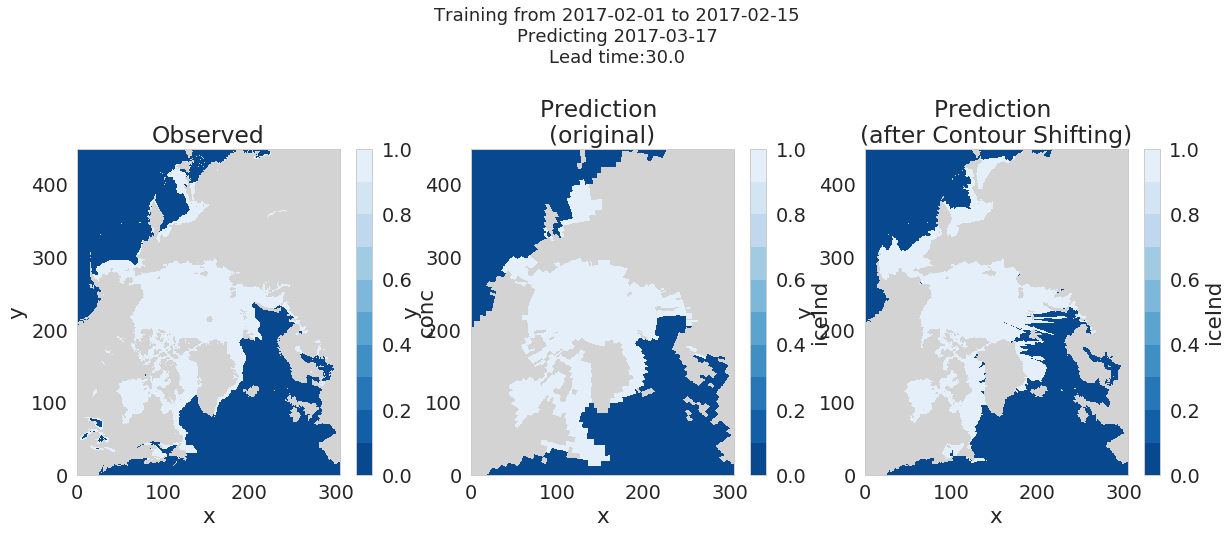

In [17]:
# Print out comparison plots of ice presence
for cyear in ds_mod_adj.years.values:
    for cmonth in ds_mod_adj.months.values:
        # Offset defined by cmonth (predcition lead time in days)
        endYearOffset = cmonth
        Train_days = cmonth
        
        # Get Training and Prediction periods
        target = pd.to_datetime(ds_mod.sel(months=cmonth, years=cyear).valid_time.values).strftime('%Y-%m-%d')
        TS = pd.to_datetime(ds_mod.sel(months=cmonth, years=np.max([cyear-endYearOffset-Train_days, 1])).valid_time.values).strftime('%Y-%m-%d')
        TE = pd.to_datetime(ds_mod.sel(months=cmonth, years=cyear-endYearOffset).valid_time.values).strftime('%Y-%m-%d')
        title_text = "Training from "+TS+" to "+TE+"\nPredicting "+target+"\nLead time:"+str(cmonth)

        # Compare obs, model, adjusted model
        f = plt.figure(figsize=((20,6)))
        plt.text(0.5,1.1,title_text, fontsize=18, horizontalalignment='center')
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')

        plt.subplot(1,3,1)
        obs_sip.sel(years=cyear,months=cmonth).plot(cmap=cmap_c)
        plt.title('Observed')

        plt.subplot(1,3,2)
        #(mod_sip.sel(years=cyear,months=cmonth)-obs_sip.sel(years=cyear,months=cmonth)).plot(cmap=cmap_c)
        mod_sip.sel(years=cyear,months=cmonth).plot(cmap=cmap_c)
        plt.title('Prediction \n(original)')

        plt.subplot(1,3,3)
        #(mod_sip_adj.sel(years=cyear,months=cmonth)-obs_sip.sel(years=cyear,months=cmonth)).plot(cmap=cmap_c)
        mod_sip_adj.sel(years=cyear,months=cmonth).plot(cmap=cmap_c)
        plt.title('Prediction \n(after Contour Shifting)')
        
        f.text(0.5, 1.08, title_text, fontsize=18, horizontalalignment='center')